# **Poject Introduction**

As part of the project fo CS598 - Deep learning for Healthcare project work. I will be trying to reproudce the results for the Paper, details of the paper below:

Link to the Paper: https://pubmed.ncbi.nlm.nih.gov/34127241/

GitHub Page: https://github.com/tanlab/ConvolutionMedicalNer



First let's import basic libraries that we need for this Project.

If below libraries are not installed in your machine, please use pip command to install them on the machine. 

In [ ]:
%%capture
!pip install https://huggingface.co/kormilitzin/en_core_med7_lg/resolve/main/en_core_med7_lg-any-py3-none-any.whl

In [ ]:
import pandas as pd
import os
import sys
import numpy as np
import torch

Also, lets import the libraries (function and class) build specific for this project. These files do have some additional python pacakges used, please install those pacakges if not there in the environment. If this is running in google Colab , you would need to sync your colab environment with google drive first. 

In [ ]:
py_file_location = "/content/drive/My Drive/DLHC-Code/" #give your library director here.
sys.path.append(os.path.abspath(py_file_location))
from project_data_prep_lib import data_prep_time_series, mean, convert_txt_to_entity, convert_ent_to_embedding, get_embd_array
from project_model_lib import CustomDataset, BaseModel, MultiModel, TransformerModel, eval_model, EarlyStopper, BestModelCheckPoint, SaveAllResults, train_model

Let's set the directories for the data file that we are going to use for this project. 

We will primary use two main files for our project. 
Similar to original paper, we will use MCMIC-III dataset and also there is pre-processed dataset of MCMIC-III from another project called , MIMIC extract that we will be using (similar to original paper): 

Gihub Page: https://github.com/MLforHealth/MIMIC_Extract

In [ ]:
#MIMIC_EXTRACT file-name. Hourly file. (Time-series Data) 
MIMIC_EXTRACT_FILE = "./drive/MyDrive/DLHC-Data/all_hourly_data.h5"

#Clinical Notes from MIMIC
CLINICAL_NOTES_FILE = "./drive/MyDrive/DLHC-Data/NOTEEVENTS.csv.gz"

TEMP_DATA_DIR = "./drive/MyDrive/DLHC-Data/temp_data/"

# **Data Import/Extraction and Cohort Creation**

In this section, we will import the required data and go through the data cohort creation for the project.
- First "patients" data is extracted and goes through the pre-processing of only selecting the patients with at-least 30 hours window (24 hours data window and 6 hours gap). 
- Then two target variables los_3 and los_7 are created using 'los_icu'. Othe two target variables (in_host_mort and in_icu_mort) are already there in the dataset.

In [ ]:
#Define the Window and Gap for our dataset.
DATA_WINDOW_SIZE = 24 #hours
DATA_GAP_SIZE = 6 #hours
DATA_MIN_SIZE = DATA_WINDOW_SIZE + DATA_GAP_SIZE #30 hours

In [ ]:
#Read the dataset from MIMIC_EXTRACT
patients_df = pd.read_hdf(MIMIC_EXTRACT_FILE, 'patients')
print("Total Patient Before selection Size: {}".format(patients_df.shape))
#We are only going to use mortality hospital, mortality icu and lenght of stay ICU from this dataset
#Making sure that cohart of data that we are going to use is from the WINDOW and GAP size we defined. 
patients_df = patients_df[patients_df.max_hours > DATA_MIN_SIZE]

#The mort_hosp and mort_icu are already in 0 and 1 values , which we need. But los_icu is in hours. 
#For our target we need los more than 3 hours and more than 7 hours. So, let's build that columns.
patients_df['los_3'] = patients_df['los_icu'] > 3
patients_df['los_7'] = patients_df['los_icu'] > 7
patients_df.drop(columns=['los_icu'], inplace=True)
patients_df = patients_df.reset_index()
patients_df.rename(columns = {"subject_id": "SUBJECT_ID", "hadm_id": "HADM_ID"}, inplace=True)
print("Patient Cohort Size: {}".format(patients_df.shape))

Total Patient Before selection Size: (34472, 28)
Patient Cohort Size: (23944, 32)


In this section, we will import the vita-labs data.
- First "vita-labs" data is extracted and goes through the pre-processing of only selecting the records with data window of 24 hours). 
- Also, filter is applied to make sure that the data matches with the patient cohort above.

In [ ]:
time_series_df = pd.read_hdf(MIMIC_EXTRACT_FILE, "vitals_labs")
print("Time-series Overall Size before filters: {}".format(time_series_df.shape))
#There are four index in this data ['subject_id', 'hadm_id', 'icustay_id', 'hours_in']
#We will applly filter in icustay_id index to make sure that it matches with our patiens records extracted above.
#Also, we will apply filter on hours_in index to make sure that is it is below the WINDOW_SIZE
is_in_patient_cohort = time_series_df.index.get_level_values('icustay_id').isin(set(patients_df['icustay_id'].values))
time_series_df = time_series_df[is_in_patient_cohort & (time_series_df.index.get_level_values('hours_in') < DATA_WINDOW_SIZE)]
print("Time-series Size After initial time filters: {}".format(time_series_df.shape))


Time-series Overall Size before filters: (2200954, 312)
Time-series Size After initial time filters: (574656, 312)


In this section, we will import the clinical-notes data.
- First "clinical notes" data is extracted and goes through the pre-processing of excluding the discharge-summary. 
- Also, filter is applied to make sure that the clinical notes are part of patient cohort above and also are within that 24-hours window.

In [ ]:
clinical_notes_df = pd.read_csv(CLINICAL_NOTES_FILE, compression = 'gzip', low_memory=False)
print("Original Clinical Notes Size, before cohort selection/clean-up: {}".format(clinical_notes_df.shape))

#Remove Discharege Summary
note_categories = clinical_notes_df.groupby(clinical_notes_df.CATEGORY).agg(['count']).index
note_categories = list(note_categories[note_categories != 'Discharge summary'])
clinical_notes_df = clinical_notes_df[clinical_notes_df.CATEGORY.isin(note_categories)]
print("After removing Dischare Summary: {}".format(clinical_notes_df.shape))

#Remove CHARTIME as Null values.
clinical_notes_df = clinical_notes_df[~clinical_notes_df["CHARTTIME"].isnull()]
clinical_notes_df = pd.merge(clinical_notes_df[['SUBJECT_ID','HADM_ID',"CATEGORY",'CHARTTIME', 'TEXT']],
                        patients_df[['SUBJECT_ID','HADM_ID','intime']], 
                        on = ['SUBJECT_ID'],
                        how = 'inner')
print("After merging with patient cohort: {}".format(clinical_notes_df.shape))

TIMELIMIT = 1 #(1-days or 24-hours)
clinical_notes_df['CHARTTIME'] = pd.to_datetime(clinical_notes_df['CHARTTIME'])
clinical_notes_df["gap_time"] = ((clinical_notes_df['CHARTTIME']-clinical_notes_df['intime']).dt.total_seconds())/(24.0*60*60)
clinical_notes_df = clinical_notes_df[clinical_notes_df["gap_time"]<TIMELIMIT]
print("After all pre-processing is done: {}".format(clinical_notes_df.shape))

Original Clinical Notes Size, before cohort selection/clean-up: (2083180, 11)
After removing Dischare Summary: (2023528, 11)
After merging with patient cohort: (745974, 7)
After all pre-processing is done: (181483, 8)


After we have a clinical-notes dataset it goes through the follwing steps:
- Extract entities from the clinical notes.
- Convert the entities extrcted into the vector representation (using word2Vec method)
- As this process runs for long time, loops and 1000 datapoints per loop is used, so that we can re-start from the point of failure if we have to restart.

In [ ]:
import math
length_in_k = math.ceil(clinical_notes_df.shape[0]/1000)

size = 1000
for i in range(length_in_k):
  name = TEMP_DATA_DIR + "notes_with_embedding_" + str(i) + ".pk1"
  if os.path.exists(name):
    continue
  else:
    start = i*size
    end = (i+1) * (size)
    batch = clinical_notes_df[start:end]
    batch['entity'] = batch['TEXT'].apply(lambda x:convert_txt_to_entity(x))
    batch['embd'] = batch['entity'].apply(lambda x:convert_ent_to_embedding(x))
    pd.to_pickle(batch, name)

In [ ]:
new_note = []
for i in range(length_in_k):
  name = TEMP_DATA_DIR + "notes_with_embedding_" + str(i) + ".pk1"
  batch =  pd.read_pickle(name)
  if i == 0:
    new_note = batch
  else:
    new_note = pd.concat([new_note, batch], ignore_index=True, sort=False)
clinical_notes_df = new_note

clinical_notes_df["vec_len"] = clinical_notes_df['embd'].apply(lambda x:len(x))
clinical_notes_df = clinical_notes_df[clinical_notes_df["vec_len"] > 0]

name = TEMP_DATA_DIR + "notes_with_entity_and_embedding_raw.pk1"
pd.to_pickle(clinical_notes_df, name)

In [ ]:
print("Clinical Notes cohort at patient-level: {}".format(clinical_notes_df.shape))

Clinical Notes cohort at patient-level: (105436, 10)


Finally once we have all the dataset (Patients, Time-seires data (vital-labs) and the clinical notes). We make sure that all the dataset has same patient cohort. This is the final chort of data that is going to be used. 

In [ ]:
#Making sure both data-sets have same patient cohort. 
time_series_df = time_series_df[time_series_df.index.get_level_values('subject_id').isin(set(clinical_notes_df['SUBJECT_ID'].values))]
clinical_notes_df = clinical_notes_df[clinical_notes_df['SUBJECT_ID'].isin(set(time_series_df.index.get_level_values('subject_id')))]
patients_df = patients_df[patients_df['SUBJECT_ID'].isin(set(clinical_notes_df['SUBJECT_ID'].values))]
print("Patients Cohort Size Final: {}".format(patients_df.shape))
print("Time-series Cohort Size Final: {}".format(time_series_df.shape))
print("Clinical Notes Cohort Size Final: {}".format(clinical_notes_df.shape))


Patients Cohort Size Final: (21207, 32)
Time-series Cohort Size Final: (508968, 312)
Clinical Notes Cohort Size Final: (105436, 10)


# **Data Summary / Visualization**

Let's try to understand little bit more about the data that we are using. First let's look into different types of patients records that we have:
- Admission Type
- Gender

<Axes: title={'center': 'Patients Counts per Admission Type'}, xlabel=' Admission Type', ylabel='Patient Counts'>

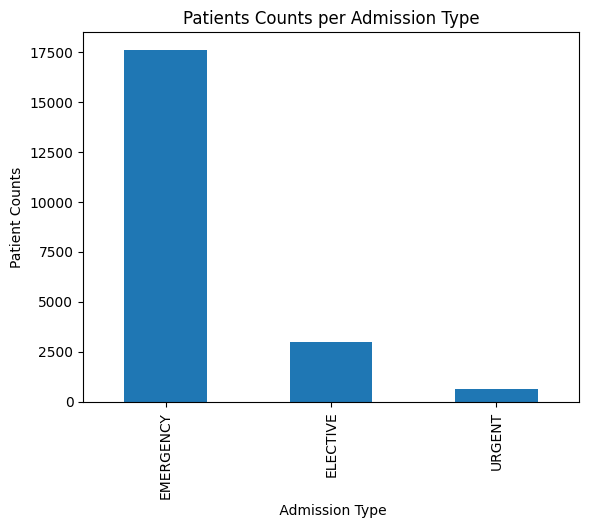

In [ ]:
patients_df['admission_type'].value_counts().plot(kind='bar',title="Patients Counts per Admission Type", xlabel = " Admission Type", ylabel = "Patient Counts")

<Axes: title={'center': 'Patients Counts per gender'}, xlabel=' gender', ylabel='Patient Counts'>

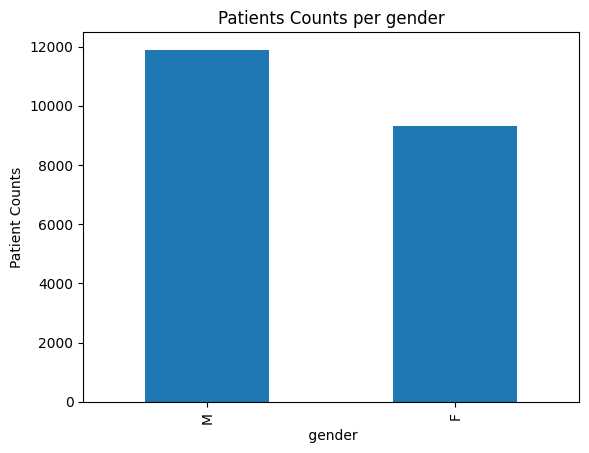

In [ ]:
patients_df['gender'].value_counts().plot(kind='bar',title="Patients Counts per gender", xlabel = " gender", ylabel = "Patient Counts")

Then let's look into the data-distribtuion for the target variable.
- Counts of positive cases in each target variable.
- Percentage to total for the positive cases.

In [ ]:
positive_case = patients_df
positive_case["Total"] = "Positive Counts"
tgt_agg =  positive_case.groupby(["Total"]).aggregate({'mort_hosp':sum, 'mort_icu':sum, 'los_3':sum,'los_7':sum})
tgt_agg = tgt_agg.reset_index()
tgt_agg.head(10)

,Total,mort_hosp,mort_icu,los_3,los_7
0,Positive Counts,2252,1496,9168,1659


In [ ]:
positive_case["Total"] = "% of Total"
tgt_agg =  positive_case.groupby(["Total"]).aggregate({'mort_hosp':'mean', 'mort_icu':'mean', 'los_3':'mean','los_7':'mean'})
#tgt_agg = tgt_agg.reset_index()
tgt_agg = (tgt_agg) * 100
tgt_agg.head(10)

,mort_hosp,mort_icu,los_3,los_7
Total,,,,
% of Total,10.619135,7.054275,43.231009,7.822889


After that we look into stats for the 104 different metrics that is used for the time-series data.

In [ ]:
idx = pd.IndexSlice
data_mean = time_series_df.loc[:, idx[:,'mean']].mean(axis=0)
data_std = time_series_df.loc[:, idx[:,'mean']].std(axis=0)
all_array = []
for i in range(len(data_mean)):
  all_array.append([data_mean.index[i][0], data_mean[i], data_std[i]])
all_array = pd.DataFrame(all_array)
all_array.columns = ["Feature", "Mean (for Mean)", "Std (For Mean)"]
display(all_array)

,Feature,Mean (for Mean),Std (For Mean)
0,alanine aminotransferase,257.694541,896.060392
1,albumin,3.158978,0.692923
2,albumin ascites,1.826562,0.881241
3,albumin pleural,1.788710,0.645312
4,albumin urine,46.740278,93.001708
...,...,...,...
99,weight,81.775630,23.435106
100,white blood cell count,12.515663,10.179809
101,white blood cell count urine,23.270444,76.539897
102,ph,7.371031,0.078669


Finally, let's look into the notes dataset and see what type of notes are been used.

<Axes: title={'center': 'Note Counts per category'}, xlabel='Category', ylabel='Counts'>

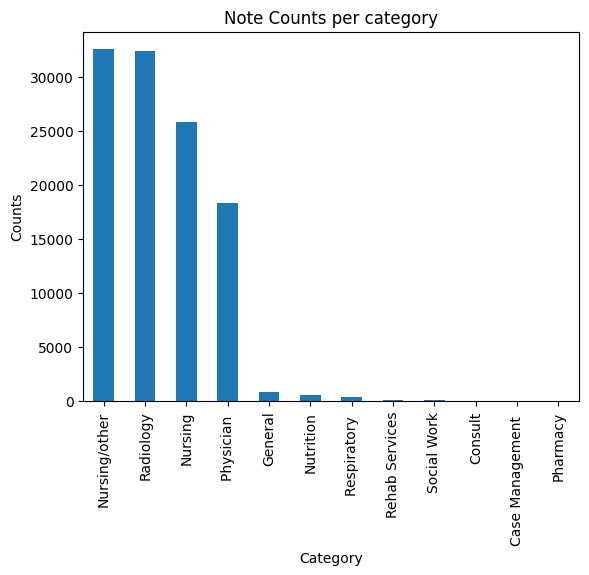

In [ ]:
clinical_notes_df['CATEGORY'].value_counts().plot(kind='bar',title="Note Counts per category", xlabel = "Category", ylabel = "Counts")

# **Data Split and Feature Creation**

After we have our dataset reday now, we will work on feature creation:

**Vital Labs\Time-series Data:**

- Frist we split the data into training (70%), validation (10%) and testing(20%)
- After that the training data is used to normalized the enterity of the dataset.
- After we have the normalized data, the vital-labs data goes through the data preperation where the Null values (NA) are been elimiated using forward fill technique per patient. 

In [ ]:
SEED = 10

#Train, Valildation and Test Percentages.
train_perc = 0.7
val_perc = 0.1
test_perc = 0.2

#Get all the Patient ID (Subject ID) from the data, and put it in a set.
patient_ids = time_series_df.index.get_level_values('subject_id')
patient_set = set(patient_ids)

#Now generate Train, Validation and Test Sets randomly.
np.random.seed(SEED)
patient_set = np.random.permutation(list(patient_set))
data_len = len(patient_set)

N_train, N_val, N_test = int(train_perc * data_len), int(val_perc * data_len), int(test_perc * data_len)

train_ids = patient_set[:N_train]
val_ids   = patient_set[N_train:N_train + N_val]
test_ids  = patient_set[N_train+N_val:]

time_series_trn = time_series_df[time_series_df.index.get_level_values('subject_id').isin(train_ids)]
time_series_val = time_series_df[time_series_df.index.get_level_values('subject_id').isin(val_ids)]
time_series_tst = time_series_df[time_series_df.index.get_level_values('subject_id').isin(test_ids)]

In [ ]:
%%capture
data_mean = time_series_trn.loc[:, idx[:,'mean']].mean(axis=0)
data_std = time_series_trn.loc[:, idx[:,'mean']].std(axis=0)

time_series_trn.loc[:, idx[:,'mean']] = (time_series_trn.loc[:, idx[:,'mean']] - data_mean)/data_std
time_series_val.loc[:, idx[:,'mean']] = (time_series_val.loc[:, idx[:,'mean']] - data_mean)/data_std
time_series_tst.loc[:, idx[:,'mean']] = (time_series_tst.loc[:, idx[:,'mean']] - data_mean)/data_std

In [ ]:
time_series_trn = data_prep_time_series(time_series_trn)
time_series_val = data_prep_time_series(time_series_val)
time_series_tst = data_prep_time_series(time_series_tst)

**Clinical Notes:**

- Clinical notes data uses the same split done for traning, validation and testing.
- After that the data goes through the entity extraction and creating the embeding vector for those entity using word2Vec method.  

In [ ]:
clinical_notes_df = clinical_notes_df.sort_values(['SUBJECT_ID']).reset_index(drop=True)
clinical_notes_df = clinical_notes_df.groupby(["SUBJECT_ID"]).aggregate({'embd':list})
clinical_notes_df = clinical_notes_df.reset_index()

In [ ]:
clinical_notes_trn = clinical_notes_df[clinical_notes_df['SUBJECT_ID'].isin(train_ids)]
clinical_notes_val = clinical_notes_df[clinical_notes_df['SUBJECT_ID'].isin(val_ids)]
clinical_notes_tst = clinical_notes_df[clinical_notes_df['SUBJECT_ID'].isin(test_ids)]

In [ ]:
patients_df = patients_df.sort_values(['SUBJECT_ID']).reset_index(drop=True)

Finally, before converting to pytorch we make sure that all the data is ordered in the right way so that the data is aligned for the training.

In [ ]:
ts_trn_ids = np.array(time_series_trn.index.get_level_values('subject_id')).reshape(-1,24)[:,0]
ts_val_ids = np.array(time_series_val.index.get_level_values('subject_id')).reshape(-1,24)[:,0]
ts_tst_ids = np.array(time_series_tst.index.get_level_values('subject_id')).reshape(-1,24)[:,0]

notes_trn_ids = (clinical_notes_trn["SUBJECT_ID"]).values
notes_val_ids = (clinical_notes_val["SUBJECT_ID"]).values
notes_tst_ids = (clinical_notes_tst["SUBJECT_ID"]).values

trg_trn_ids = (patients_df[patients_df["SUBJECT_ID"].isin(train_ids)]["SUBJECT_ID"]).values
trg_val_ids = (patients_df[patients_df["SUBJECT_ID"].isin(val_ids)]["SUBJECT_ID"]).values
trg_tst_ids = (patients_df[patients_df["SUBJECT_ID"].isin(test_ids)]["SUBJECT_ID"]).values

### Data Alingement Check
trn_align_tst = sum(ts_trn_ids - notes_trn_ids) + sum(ts_trn_ids - trg_trn_ids)
val_align_tst = sum(ts_val_ids - notes_val_ids) + sum(ts_val_ids - trg_val_ids)
tst_align_tst = sum(ts_tst_ids - notes_tst_ids) + sum(ts_tst_ids - trg_tst_ids)
print("Training Alignment Error? {}".format(trn_align_tst != 0))
print("Validation Alignment Error? {}".format(val_align_tst != 0))
print("Test Alignment Error? {}".format(tst_align_tst != 0))

Training Alignment Error? False
Validation Alignment Error? False
Test Alignment Error? False


Next, data is converted from pandas data-frame to pytorch tensors that is going to be used for model traning, validation and testing. 

In [ ]:
time_series_trn_py_torch = torch.tensor(time_series_trn.loc[:, idx[:, 'mean']].values).float()
time_series_val_py_torch = torch.tensor(time_series_val.loc[:, idx[:, 'mean']].values).float()
time_series_tst_py_torch = torch.tensor(time_series_tst.loc[:, idx[:, 'mean']].values).float()

time_series_trn_py_torch = torch.reshape(time_series_trn_py_torch, (int(time_series_trn_py_torch.size()[0]/24), 24,104))
time_series_val_py_torch = torch.reshape(time_series_val_py_torch, (int(time_series_val_py_torch.size()[0]/24), 24,104))
time_series_tst_py_torch = torch.reshape(time_series_tst_py_torch, (int(time_series_tst_py_torch.size()[0]/24), 24,104))

print("Time-series tranining data size: {}".format(time_series_trn_py_torch.size()))
print("Time-series validation data size: {}".format(time_series_val_py_torch.size()))
print("Time-series test data size: {}".format(time_series_tst_py_torch.size()))

Time-series tranining data size: torch.Size([14844, 24, 104])
Time-series validation data size: torch.Size([2120, 24, 104])
Time-series test data size: torch.Size([4243, 24, 104])


In [ ]:
notes_trn_ids, notes_trn_py_torch = get_embd_array(clinical_notes_trn)
notes_tst_ids, notes_val_py_torch = get_embd_array(clinical_notes_val)
notes_val_ids, notes_tst_py_torch = get_embd_array(clinical_notes_tst)

notes_trn_py_torch = torch.tensor(notes_trn_py_torch).float()
notes_val_py_torch = torch.tensor(notes_val_py_torch).float()
notes_tst_py_torch = torch.tensor(notes_tst_py_torch).float()

In [ ]:
print("Clinical Notes tranining data size: {}".format(notes_trn_py_torch.size()))
print("Clinical Notes validation data size: {}".format(notes_val_py_torch.size()))
print("Clinical Notes test data size: {}".format(notes_tst_py_torch.size()))

Clinical Notes tranining data size: torch.Size([14844, 64, 100])
Clinical Notes validation data size: torch.Size([2120, 64, 100])
Clinical Notes test data size: torch.Size([4243, 64, 100])


In [ ]:
y_trn = patients_df[patients_df['SUBJECT_ID'].isin(train_ids)]
y_val = patients_df[patients_df['SUBJECT_ID'].isin(val_ids)]
y_tst = patients_df[patients_df['SUBJECT_ID'].isin(test_ids)]
y_trn_mort_hosp = torch.tensor(y_trn["mort_hosp"].values).float()
y_val_mort_hosp = torch.tensor(y_val["mort_hosp"].values).float()
y_tst_mort_hosp = torch.tensor(y_tst["mort_hosp"].values).float()

y_trn_mort_icu = torch.tensor(y_trn["mort_icu"].values).float()
y_val_mort_icu = torch.tensor(y_val["mort_icu"].values).float()
y_tst_mort_icu = torch.tensor(y_tst["mort_icu"].values).float()

y_trn_los_3 = torch.tensor(y_trn["los_3"].values).float()
y_val_los_3 = torch.tensor(y_val["los_3"].values).float()
y_tst_los_3 = torch.tensor(y_tst["los_3"].values).float()

y_trn_los_7 = torch.tensor(y_trn["los_7"].values).float()
y_val_los_7 = torch.tensor(y_val["los_7"].values).float()
y_tst_los_7 = torch.tensor(y_tst["los_7"].values).float()

print("Hospital Mortality train data size: {}".format(y_trn_mort_hosp.size()))
print("Hospital Mortality validation data size: {}".format(y_val_mort_hosp.size()))
print("Hospital Mortality test data size: {}".format(y_tst_mort_hosp.size()))

print("Hospital Mortality train data size: {}".format(y_trn_mort_icu.size()))
print("Hospital Mortality validation data size: {}".format(y_val_mort_icu.size()))
print("Hospital Mortality test data size: {}".format(y_tst_mort_icu.size()))

print("Hospital Mortality train data size: {}".format(y_trn_los_3.size()))
print("Hospital Mortality validation data size: {}".format(y_val_los_3.size()))
print("Hospital Mortality test data size: {}".format(y_tst_los_3.size()))

print("Hospital Mortality train data size: {}".format(y_trn_los_7.size()))
print("Hospital Mortality validation data size: {}".format(y_val_los_7.size()))
print("Hospital Mortality test data size: {}".format(y_tst_los_7.size()))

Hospital Mortality train data size: torch.Size([14844])
Hospital Mortality validation data size: torch.Size([2120])
Hospital Mortality test data size: torch.Size([4243])
Hospital Mortality train data size: torch.Size([14844])
Hospital Mortality validation data size: torch.Size([2120])
Hospital Mortality test data size: torch.Size([4243])
Hospital Mortality train data size: torch.Size([14844])
Hospital Mortality validation data size: torch.Size([2120])
Hospital Mortality test data size: torch.Size([4243])
Hospital Mortality train data size: torch.Size([14844])
Hospital Mortality validation data size: torch.Size([2120])
Hospital Mortality test data size: torch.Size([4243])


# **Model Traning, Validation and Testing**

After the feature creation, we go through the model traning, validaiton and testing:

- There are three models used (base-model, multi-model and transformer-model). Please refer the library file for the detail of the model implementation. Transformer model here is a additional model which is not part of original paper.
- Each model does have early stop creiteria (details in library file). This is how that works, if the validation loss doesn't improve until the patience period (which is set as 5) the model traning will exit. 
- Also, the model checkpoint is used where the model which has the least validation loss is saved and reterived later on after the traning is done.
- The model selected from above process is used for prediction in test-data.
- The result reported is from the test data. The overall process of training, validation and testing is carried out for five different times and the average results is reported.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128
max_epoch = 100
lern_rate = 0.001

y_typ_list = ['mort_hosp', 'mort_icu', 'los_3', 'los_7']
y_trn_list = [y_trn_mort_hosp, y_trn_mort_icu, y_trn_los_3, y_trn_los_7]
y_val_list = [y_val_mort_hosp, y_val_mort_icu, y_val_los_3, y_val_los_7]
y_tst_list = [y_tst_mort_hosp, y_tst_mort_icu, y_tst_los_3, y_tst_los_7]

criterion = nn.BCELoss()
all_run_result = SaveAllResults("./drive/MyDrive/DLHC-Data/pre_processed_data/models/results.pk1")
for run in range(5):
  print("RUN--------{:.4f}".format((run+1)))
  all_result = []
  for y_typ, y_trn, y_val, y_tst in zip(y_typ_list, y_trn_list, y_val_list, y_tst_list):
    print("#####################################################################")
    print(y_typ)
    trn_dataset = CustomDataset(time_series_trn_py_torch, notes_trn_py_torch, y_trn)
    val_dataset = CustomDataset(time_series_val_py_torch, notes_val_py_torch, y_val)
    tst_dataset = CustomDataset(time_series_tst_py_torch, notes_tst_py_torch, y_tst)

    trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    tst_loader = DataLoader(tst_dataset, batch_size=batch_size, shuffle=False)

    print("######BASE MODEL#####")
    model_name = "base_model_" + y_typ
    basemodel = BaseModel(input_size=104, hidden_size=256)
    basemodel = train_model(basemodel,trn_loader,val_loader, model_name, n_epochs = max_epoch, lr = lern_rate, patience = 5, lr_scheduler=True)
    auroc, auprc, f1, acc, tst_loss = eval_model(basemodel, tst_loader, criterion)
    print('Test auroc: {:.4f}, auprc:{:.4f}, f1: {:.4f}, acc: {:.4f}'.format(auroc, auprc, f1, acc))
    all_run_result.save_result(y_typ, "base_model", (run+1), auroc, auprc, f1, acc) 

    print("######MULTI MODEL#######")
    model_name = "multi_model_" + y_typ
    multi_model = MultiModel(input_size=104, hidden_size=256, filter_size=32)
    multi_model = train_model(multi_model,trn_loader,val_loader, model_name, n_epochs = max_epoch, lr = lern_rate, patience = 5, lr_scheduler=True)
    auroc, auprc, f1, acc, tst_loss = eval_model(multi_model, tst_loader, criterion)
    print('Test auroc: {:.4f}, auprc:{:.4f}, f1: {:.4f}, acc: {:.4f}'.format(auroc, auprc, f1, acc))
    all_run_result.save_result(y_typ, "multi_model", (run+1), auroc, auprc, f1, acc) 

    print("#######TRANSFORMER MODEL#######")
    model_name = "transformer_model_" + y_typ
    trn_model = TransformerModel(input_size=104, num_heads=8, num_layers=1)
    trn_model = train_model(trn_model,trn_loader,val_loader, model_name, n_epochs = max_epoch, lr = lern_rate, patience = 5, lr_scheduler=True)
    auroc, auprc, f1, acc, tst_loss = eval_model(trn_model, tst_loader, criterion)
    print('Test auroc: {:.4f}, auprc:{:.4f}, f1: {:.4f}, acc: {:.4f}'.format(auroc, auprc, f1, acc))
    all_run_result.save_result(y_typ, "transformer_model", (run+1), auroc, auprc, f1, acc) 
                           

The printed output of each run above was deleted because the log was really long. Below table shows all the results for each run, which was used to report the result.

In [ ]:
all_run_result = SaveAllResults("./drive/MyDrive/DLHC-Data/pre_processed_data/models/results.pk1")
all_run = all_run_result.get_result()
all_run = all_run.sort_values(['run_id', 'var_name','model_name']).reset_index(drop=True)
all_run.head(100)

,var_name,model_name,run_id,auroc,auprc,f1,acc
0,los_3,base_model,1,0.686103,0.630927,0.526484,0.650247
1,los_3,multi_model,1,0.689697,0.636548,0.541944,0.658968
2,los_3,transformer_model,1,0.694085,0.634910,0.519256,0.658732
3,los_7,base_model,1,0.700557,0.176523,0.000000,0.921753
4,los_7,multi_model,1,0.690962,0.173636,0.017751,0.921753
5,los_7,transformer_model,1,0.716034,0.189339,0.000000,0.921753
6,mort_hosp,base_model,1,0.854717,0.511226,0.385294,0.901485
7,mort_hosp,multi_model,1,0.856073,0.498737,0.375963,0.904549
8,mort_hosp,transformer_model,1,0.861665,0.530665,0.336026,0.903135
9,mort_icu,base_model,1,0.883021,0.466147,0.361174,0.933302


In [ ]:
rslt_agg = all_run.groupby(["var_name", "model_name"]).aggregate({'auroc':'mean', 'auprc':'mean', 'f1':'mean', 'acc':'mean'})
rslt_agg.head(12)

auroc     auprc        f1       acc
var_name  model_name                                               
los_3     base_model         0.685670  0.630393  0.529816  0.653453
          multi_model        0.685939  0.632426  0.537804  0.655150
          transformer_model  0.693885  0.635302  0.532977  0.659533
los_7     base_model         0.695697  0.178854  0.000000  0.921753
          multi_model        0.699644  0.176603  0.010669  0.921706
          transformer_model  0.716880  0.188451  0.000000  0.921753
mort_hosp base_model         0.854759  0.512248  0.379022  0.900872
          multi_model        0.853941  0.498266  0.365909  0.902993
          transformer_model  0.860957  0.529489  0.337326  0.903370
mort_icu  base_model         0.880726  0.456379  0.353283  0.933066
          multi_model        0.876264  0.452141  0.343004  0.936460
          transformer_model  0.887242  0.475564  0.295960  0.936507

# Reproducibility Summary and Discusssion
As shown above by the result multi-model was not able to beat the performance of the base-model for most of the cases. The results observed are very close within 1-3% ponts difference between one another (mostly just a %point). 

There might be multipe reason why this project was not able to replicate the same result of the original paper, some of them being:

- Use of different deep learning framework : The original project uses keras and this project uses pytorch. Although same model architecture is used, different framework might have different way of calcuating things causing the results to vary. 

- Data imbalance and it's sensativity to reported result - Below it show's how sensative is the changes in positive classes for the imbalanced datasets. For example our in-hospatility mortality has 10% of positive class. So, we will take that as example and do follwoing things:
  - Change the predicted values for postive class (which were predicted as -ve previously to be positive and change the score from below 0.5 to above 0.5 for the same). 
  - See the new result on the metrics that were reported. 

In [ ]:
# Frist let's import the model that was the best-model for multi-model and use that for predicting the outcome.
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

tst_dataset = CustomDataset(time_series_tst_py_torch, notes_tst_py_torch, y_tst_mort_hosp)
tst_loader = DataLoader(tst_dataset, batch_size=128, shuffle=False)
criterion = nn.BCELoss()

model = MultiModel(input_size=104, hidden_size=256, filter_size=32)
ckpoint = BestModelCheckPoint("./drive/MyDrive/DLHC-Data/pre_processed_data/models/multi_model_mort_hosp")
model = ckpoint.get_best_model(model)
auroc_bc, auprc_bc, f1_bc, acc_bc, tst_loss = eval_model(model, tst_loader, criterion)
print("Prediction for the Model before change.")
print('Test auroc: {:.4f}, auprc:{:.4f}, f1: {:.4f}, acc: {:.4f}'.format(auroc_bc, auprc_bc, f1_bc, acc_bc))

Prediction for the Model before change.
Test auroc: 0.8519, auprc:0.4957, f1: 0.3537, acc: 0.9027


In [ ]:
y_pred = torch.LongTensor()
y_true = torch.LongTensor()
y_score = torch.Tensor()

for x, x_embd, y in tst_loader:
    y_hat = model(x,x_embd)
    all_y_true = y.reshape(y_hat.shape)

    y_score = torch.cat((y_score,  y_hat.detach().to('cpu')), dim=0)
    y_hat = torch.Tensor([1 if i>=0.5 else 0 for i in y_hat])
    y_pred = torch.cat((y_pred,  y_hat.detach().to('cpu')), dim=0)
    y_true = torch.cat((y_true, all_y_true.detach().to('cpu')), dim=0)
    
y_score = torch.squeeze(y_score).tolist()
y_pred = torch.squeeze(y_pred).tolist()
y_true = torch.squeeze(y_true).tolist()

In [ ]:
change_data_len = 0
for i in range(len(y_pred)):
  if ((y_pred[i] < y_true[i])):
    print("Originaal :: y_pred:{}, y_true:{}, y_score_model:{}".format(y_pred[i], y_true[i], y_score[i]))
    y_pred[i] = 1.0
    y_score[i] = 0.601
    print("Changed to :: y_pred:{}, y_true:{}, y_score_model:{}".format(y_pred[i], y_true[i], y_score[i]))
    change_data_len = change_data_len + 1
    if (change_data_len > 20):
      break

Originaal :: y_pred:0.0, y_true:1.0, y_score_model:0.09404982626438141
Changed to :: y_pred:1.0, y_true:1.0, y_score_model:0.601
Originaal :: y_pred:0.0, y_true:1.0, y_score_model:0.059709303081035614
Changed to :: y_pred:1.0, y_true:1.0, y_score_model:0.601
Originaal :: y_pred:0.0, y_true:1.0, y_score_model:0.0958065614104271
Changed to :: y_pred:1.0, y_true:1.0, y_score_model:0.601
Originaal :: y_pred:0.0, y_true:1.0, y_score_model:0.04858127981424332
Changed to :: y_pred:1.0, y_true:1.0, y_score_model:0.601
Originaal :: y_pred:0.0, y_true:1.0, y_score_model:0.0615299753844738
Changed to :: y_pred:1.0, y_true:1.0, y_score_model:0.601
Originaal :: y_pred:0.0, y_true:1.0, y_score_model:0.0829412117600441
Changed to :: y_pred:1.0, y_true:1.0, y_score_model:0.601
Originaal :: y_pred:0.0, y_true:1.0, y_score_model:0.1002126932144165
Changed to :: y_pred:1.0, y_true:1.0, y_score_model:0.601
Originaal :: y_pred:0.0, y_true:1.0, y_score_model:0.42307305335998535
Changed to :: y_pred:1.0, y_t

In [ ]:
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score, f1_score
print('Prediction for the Model before change: Test auroc: {:.4f}, auprc:{:.4f}, f1: {:.4f}, acc: {:.4f}'.format(auroc_bc, auprc_bc, f1_bc, acc_bc))

auroc = roc_auc_score(y_true, y_score)
auprc = average_precision_score(y_true, y_score)
f1 = f1_score(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
print('Prediction for the Model after change : Test auroc: {:.4f}, auprc:{:.4f}, f1: {:.4f}, acc: {:.4f}'.format(auroc, auprc, f1, acc))
print('Prediction for the Model changes      : Test auroc: {:.4f}, auprc:{:.4f}, f1: {:.4f}, acc: {:.4f}'.format(auroc-auroc_bc, auprc-auprc_bc, f1-f1_bc, acc-acc_bc))

Prediction for the Model before change: Test auroc: 0.8519, auprc:0.4957, f1: 0.3537, acc: 0.9027
Prediction for the Model after change : Test auroc: 0.8638, auprc:0.5294, f1: 0.4061, acc: 0.9076
Prediction for the Model changes      : Test auroc: 0.0118, auprc:0.0337, f1: 0.0524, acc: 0.0049


Above, as shown by the results the small changes in positive class (20-data points, which is about 5% of test dataset positive cases and 0.5% of test-data) does change 1-2% point for AUROC, 3-4% points of AUPRC and 5-6% points for F1 score. So, all of these measures are very sensative for the changes in the imbalanced classes.

# References

- Batuhan Bardak and Mehmet Tan (2021). Improving clinical outcome predictions using convolution over medical entities with multimodal learning. Artificial Intelligence in Medicine, Volume 117, https://doi.org/10.1016/j.artmed.2021.102112

- Batuhan Bardak and Mehmet Tan (2021). Code for paper - Improving clinical outcome predictions using convolution over medical entities with multimodal learning. https://github.com/tanlab/ConvolutionMedicalNer

- Johnson, A., Pollard, T., and Mark, R. (2016). MIMIC-III Clinical Database (version 1.4). PhysioNet. https://doi.org/10.13026/C2XW26

- Shirly Wang, Matthew B. A. McDermott, Geeticka Chauhan, Michael C. Hughes, Tristan Naumann, and Marzyeh Ghassemi. MIMIC-Extract: A Data Extraction, Preprocessing, and Representation Pipeline for MIMIC-III. arXiv:1907.08322. https://github.com/MLforHealth/MIMIC_Extract

- Kormilitzin, Andrey and Vaci, Nemanja and Liu, Qiang and Nevado-Holgado, Alejo (2020). Med7: a transferable clinical natural language processing model for electronic health records. arXiv preprint arXiv:2003.01271. https://github.com/kormilitzin/med7

- Tomas Mikolov, Kai Chen, Greg Corrado, Jeffrey Dean. Efficient Estimation of Word Representations in Vector Space. arXiv:1301.3781v3. https://doi.org/10.48550/arXiv.1301.3781

- Kexin Huang, Jaan Altosaar, Rajesh Ranganath This repo hosts pretraining and finetuning weights and relevant scripts for ClinicalBERT. https://github.com/kexinhuang12345/clinicalBERT